In [ ]:
import pandas as pd
import numpy as np
import itertools

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import (
    learning_curve, validation_curve, train_test_split, StratifiedKFold,
    RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from scipy.stats import loguniform
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as Imbpipeline
from imblearn.over_sampling import SMOTE

# Import XGBoost
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

# Loading the data

In [64]:
df = pd.read_csv('Stars.csv')

# The target variable is 'Star type'
X = df.drop('Type', axis=1)
y = df['Type']

Dataset Shape:

In [65]:
X.shape

(240, 6)

Dataset Top 5 rows:

In [68]:
print(df.head())

   Temperature         L       R    A_M Color Spectral_Class  Type
0         3068  0.002400  0.1700  16.12   Red              M     0
1         3042  0.000500  0.1542  16.60   Red              M     0
2         2600  0.000300  0.1020  18.70   Red              M     0
3         2800  0.000200  0.1600  16.65   Red              M     0
4         1939  0.000138  0.1030  20.06   Red              M     0


Target variable distribution (Star Type):

In [69]:
y.value_counts().sort_index()

Type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

Number of classes:

In [70]:
y.nunique()

6

# Preprocessing

Descriptive Statistics for Numerical Features:

In [71]:
X.describe()

,Temperature,L,R,A_M
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


In [72]:
print("\nUnique values and counts for categorical features:")
for col in X.select_dtypes(include='object').columns:
    print(f"- {col}: {X[col].nunique()} unique values")
    print(X[col].value_counts())


Unique values and counts for categorical features:
- Color: 17 unique values
Color
Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
Orange                  2
Whitish                 2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: count, dtype: int64
- Spectral_Class: 7 unique values
Spectral_Class
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: count, dtype: int64


In [73]:
numerical_features = ['Temperature', 'L', 'R', 'A_M']
categorical_features = ['Color', 'Spectral_Class']

In [74]:
# Function to standardize star color strings (e.g., 'Blue-white' -> 'blue white')
def standardize_star_color(df):
    df_copy = df.copy()
    df_copy['Color'] = df_copy['Color'].str.lower().str.replace('-', ' ').str.strip()
    return df_copy

In [76]:
# Pipeline for numerical features: Imputation (if any, though none expected here) and Scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [ ]:
# Pipeline for categorical features: Standardizing text, Imputation, and One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('spectral_class', categorical_transformer, ['Spectral_Class']) # Generic categorical for others
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0 
)


Sanity check for initial pipeline:
Error during initial pipeline sanity check: A given column is not a column of the dataframe


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Model Selection

In [92]:
# Initial pipeline structure for nested cross-validation
model_pipeline = Imbpipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', LogisticRegression())
])

In [93]:
print("\nSanity check for initial pipeline:")
try:
    model_pipeline.fit(X_train, y_train)
    _ = model_pipeline.predict(X_test)
    print("Initial pipeline fit and predict successful.")
except Exception as e:
    print(f"Error during initial pipeline sanity check: {e}")


Sanity check for initial pipeline:
Initial pipeline fit and predict successful.


In [94]:
# Define hyperparameter configurations for different classifiers
# For multi-class, `class_weight='balanced'` is applicable to some sklearn models.
# For XGBoost, `objective='multi:softmax'` and `num_class` are important.
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
]

classifier_configs = [
    {
        'classifier': [LogisticRegression(solver='saga', multi_class='multinomial', max_iter=2000, random_state=42, class_weight='balanced')],
        'classifier__C': loguniform(0.001, 100),
        'classifier__penalty': ['l1', 'l2']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'classifier__n_estimators': [50, 100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    {
        'classifier': [DecisionTreeClassifier(random_state=42, class_weight='balanced')],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    {
        'classifier': [XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False,
                                      objective='multi:softmax', num_class=y.nunique())],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.7, 0.8, 0.9],
        'classifier__colsample_bytree': [0.7, 0.8, 0.9],
        # For multi-class imbalance in XGBoost, no direct `scale_pos_weight`.
        # You'd rely on `f1_weighted` scoring and potentially `min_child_weight`.
        # 'classifier__min_child_weight': [1, 5, 10]
    }
]

In [95]:
all_configs = []
for sampler_config, dim_reduction_config, classifier_config in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    combined_config = {}
    combined_config.update(sampler_config)
    combined_config.update(dim_reduction_config)
    combined_config.update(classifier_config)
    all_configs.append(combined_config)

print(f"\nNumber of different base classifier configurations for RandomizedSearchCV: {len(all_configs)}")


Number of different base classifier configurations for RandomizedSearchCV: 24


In [96]:
all_configs = []
for config_dict in classifier_configs:
    all_configs.append(config_dict)

print(f"\nNumber of different base classifier configurations for RandomizedSearchCV: {len(all_configs)}")


Number of different base classifier configurations for RandomizedSearchCV: 6


In [97]:
# Define RandomizedSearchCV for the inner loop
rs = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=all_configs,
    n_iter=50, # Number of parameter settings that are sampled. Adjust based on computational budget.
    n_jobs=-1, # Use all available CPU cores
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # Inner CV for hyperparameter tuning
    scoring='f1_weighted', # F1-score weighted by support for multi-class
    random_state=42, # For reproducibility of random sampling
)

In [98]:
# Implement the outer loop using cross_validate (Nested Cross-Validation)
print("\nStarting nested cross-validation (this may take some time)...")
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Outer CV for robust model evaluation

scores = cross_validate(rs, X_train, y_train,
                        scoring='f1_weighted', # Consistent F1-weighted score for evaluation
                        cv=outer_cv,
                        return_estimator=True, # Important to get the best estimator from each inner fold
                        verbose=3,
                        n_jobs=-1) # Use parallel processing for outer folds if possible

print("\nNested cross-validation complete.")
print("Cross-validation F1-weighted scores for each fold:", scores['test_score'])
print(f"Mean F1-weighted score across outer folds: {np.mean(scores['test_score']):.4f}")
print(f"Standard deviation of F1-weighted score across outer folds: {np.std(scores['test_score']):.4f}")


Starting nested cross-validation (this may take some time)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.8s remaining:   59.7s



Nested cross-validation complete.
Cross-validation F1-weighted scores for each fold: [1.         1.         0.97350018 1.         0.97368421]
Mean F1-weighted score across outer folds: 0.9894
Standard deviation of F1-weighted score across outer folds: 0.0129


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.3s finished


In [100]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE()
PCA(n_components=0.8)
KNeighborsClassifier(n_neighbors=9, weights='distance') {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
1.0
----------
SMOTE()
PCA(n_components=0.8)
KNeighborsClassifier(weights='distance') {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
1.0
----------
SMOTE()
PCA(n_components=0.8)
KNeighborsClassifier(n_neighbors=3, weights='distance') {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.9735001840264998
----------
SMOTE()
PCA(n_components=0.8)
KNeighborsClassifier(n_neighbors=3, weights='distance') {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
1.0
-------

In [102]:
best_overall_f1_idx = np.argmax(scores['test_score'])
best_overall_estimator_pipeline = scores['estimator'][best_overall_f1_idx].best_estimator_

# Get the type of the best classifier for targeted refinement
best_classifier_type = type(best_overall_estimator_pipeline.named_steps['classifier'])
print(f"Refining model based on the best performing classifier from nested CV: {best_classifier_type.__name__}")

Refining model based on the best performing classifier from nested CV: KNeighborsClassifier


In [113]:
# Define a specific pipeline for refinement using the structure and best classifier found
refined_model_pipeline = Imbpipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', best_overall_estimator_pipeline.named_steps['classifier']) # Use the actual best classifier instance
])

# Define a narrower parameter search space for refinement based on the best classifier's type
refinement_params = {
    'classifier__n_neighbors': [3,4],
    'dim_reduction__n_components': [0.7, 0.8, 0.9]
}

In [114]:
rs_best = RandomizedSearchCV(
    estimator=refined_model_pipeline,
    param_distributions=refinement_params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
    n_iter=30, # More iterations for refinement search
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs_best.fit(X_train, y_train)

print(f"\nBest parameters after refinement: {rs_best.best_params_}")
print(f"Best F1-weighted score after refinement (on CV folds): {rs_best.best_score_:.4f}")
final_best_model = rs_best.best_estimator_

c:\Users\USER\.virtualenvs\star-type-prediction-N8362Ct2\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=30. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 15 folds for each of 6 candidates, totalling 90 fits

Best parameters after refinement: {'dim_reduction__n_components': 0.9, 'classifier__n_neighbors': 4}
Best F1-weighted score after refinement (on CV folds): 0.9930


In [115]:
# --- 8. Final Evaluation and Visualization ---
print("\n--- 8. Final Evaluation and Visualization ---")

y_test_pred_final = final_best_model.predict(X_test)

# Calculate scores using 'weighted' average for multi-class classification
final_accuracy_score = accuracy_score(y_test, y_test_pred_final)
final_precision_score = precision_score(y_test, y_test_pred_final, average='weighted', zero_division=0)
final_recall_score = recall_score(y_test, y_test_pred_final, average='weighted', zero_division=0)
final_f1_score = f1_score(y_test, y_test_pred_final, average='weighted', zero_division=0)




print(f"Final Accuracy Score on the held-out test set: {final_accuracy_score:.4f}")
print(f"Final Precision Score (weighted) on the held-out test set: {final_precision_score:.4f}")
print(f"Final Recall Score (weighted) on the held-out test set: {final_recall_score:.4f}")
print(f"Final F1-score (weighted) on the held-out test set: {final_f1_score:.4f}")


--- 8. Final Evaluation and Visualization ---
Final Accuracy Score on the held-out test set: 0.9792
Final Precision Score (weighted) on the held-out test set: 0.9815
Final Recall Score (weighted) on the held-out test set: 0.9792
Final F1-score (weighted) on the held-out test set: 0.9791


In [116]:
print("\nClassification Report on Test Set (Final Model):")
print(classification_report(y_test, y_test_pred_final, zero_division=0))


Classification Report on Test Set (Final Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       0.89      1.00      0.94         8
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00         8

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48




Confusion Matrix for the Final Model:


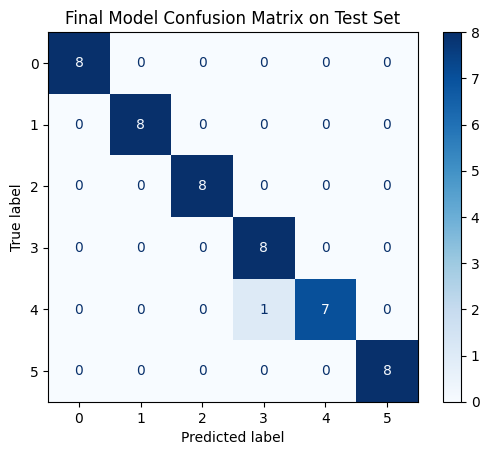

In [117]:
# Confusion Matrix for the final model
print("\nConfusion Matrix for the Final Model:")
# Display labels are automatically inferred from y_test by ConfusionMatrixDisplay
cm_final = confusion_matrix(y_test, y_test_pred_final, labels=final_best_model.classes_)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=final_best_model.classes_)
disp_final.plot(cmap=plt.cm.Blues)
plt.title("Final Model Confusion Matrix on Test Set")
plt.show()



Generating Learning Curve...


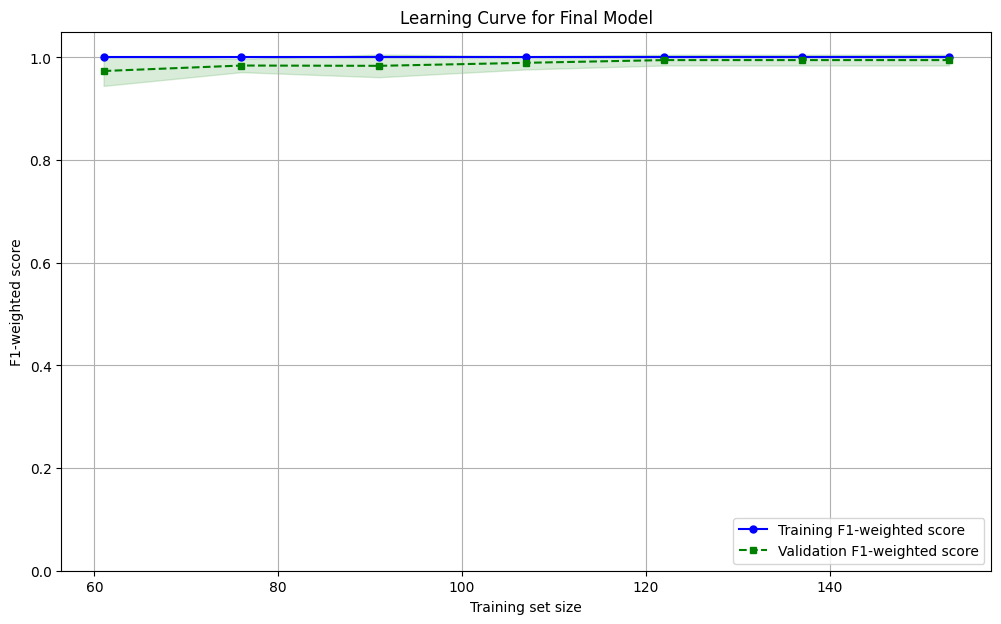

In [120]:
import warnings
warnings.filterwarnings('ignore')

# Learning Curve
print("\nGenerating Learning Curve...")
train_sizes, train_scores, test_scores = learning_curve(
    final_best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), # 10 different sizes
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='f1_weighted', # Use weighted F1 for multi-class
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1-weighted score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation F1-weighted score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Training set size')
plt.ylabel('F1-weighted score')
plt.title('Learning Curve for Final Model')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.05]) # Adjusted y-limit
plt.show()




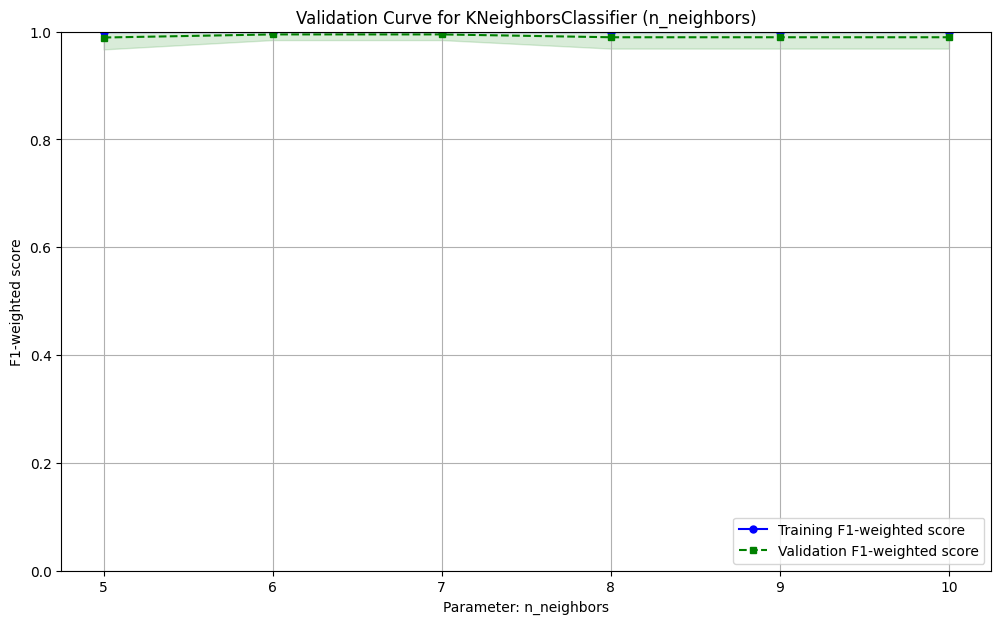

In [112]:
param_to_plot = 'n_neighbors'
param_range_vals = np.unique(np.array(refinement_params['classifier__n_neighbors']))
param_name_in_pipeline = 'classifier__n_neighbors'
    
train_scores, test_scores = validation_curve(
    final_best_model,
    X=X_train,
    y=y_train,
    param_name=param_name_in_pipeline,
    param_range=param_range_vals,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='f1_weighted' # Use weighted F1 for multi-class
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 7))
plt.plot(param_range_vals, train_mean, color='blue', marker='o', markersize=5, label='Training F1-weighted score')
plt.fill_between(param_range_vals, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range_vals, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation F1-weighted score')
plt.fill_between(param_range_vals, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel(f'Parameter: {param_to_plot}')
plt.ylabel('F1-weighted score')
plt.title(f'Validation Curve for {best_classifier_type.__name__} ({param_to_plot})')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.0])
plt.show()